In [876]:
#/////////////////////////////////////////////////////////////////////////////////////////////////// <imports nécessaires> ////

import random
import sklearn
import pandas as pd
from arftools import *
import warnings
import os
import sys
import time
from collections import Counter
# Outils classiques
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib import cm
# Ressources de TAL
import nltk
# Ressources de ML
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning

#/////////////////////////////////////////////////////////////////////////////////////////////////// <imports nécessaires> ////

In [940]:
#/////////////////////////////////////////////////////////////////////////////////////// <récupération des fonctions TME3> ////

# ··· Petits prérequis.

def do_shape(fonc):
    # Assure les dimensions des données d'entrée: X(n,d); W(1,d); Y(n,1).
    def shape(dataX,dataY,w,*args,**kwargs):
        dataX,dataY,w = dataX.reshape(len(dataY),-1),dataY.reshape(-1,1),w.reshape((1,-1))
        return fonc(dataX,dataY,w,*args,**kwargs)
    return shape

@do_shape
def hinge(dataX,dataY,w):
    # Moyenne de l'erreur hinge, soit le coût du perceptron max(0,−y<x.w>).
    return np.mean(np.maximum(0,-dataY*np.dot(dataX,w.T)))
@do_shape
def hingeG(dataX,dataY,w):
    # Gradient moyen de l'erreur hinge.
    mask = np.sign(np.maximum(0,-dataY*np.dot(dataX, w.T)))
    return np.mean(mask*(-dataY*dataX),axis=0)

# Régression Ridge (régularisation de Tikhonov) //////////////////////////////////////////////
@do_shape
def ridge(dataX,dataY,w,alpha=1):
    # Erreur aux moindres carrés, avec pénalité équivalente au carré de la norme L2 des poids.
    # Remarquons l'absence de la racine carrée.
    return hinge(dataX,dataY,w) + alpha*np.sum(w**2) 
@do_shape
def ridgeG(dataX,dataY,w,alpha=1):
    # Gradient de l'erreur Ridge.
    return hingeG(dataX,dataY,w) + 2*alpha*w 

# ··· La classe Linéaire implémente un perceptron avec une fonction de coût Hinge.

class Lineaire(object):
    def __init__(self,max_iter=1000,eps=0.01,batch_size=10,tikhonov=False):
        # :max_iter: nombre d'itérations, de pas :eps: (learning rate).
        self.max_iter, self.eps = max_iter,eps
        # :batch_size: nombre d'exemples tirés au hasard dans le cas de mini-batch
        self.batch_size = batch_size
        # allossA et allossT servent à visualiser l'évolution de l'erreur au fil des itérations.
        self.allossA, self.allossT = [], []
        # Question bonus : régularisation de Tikhonov et comparaison avec SVM linéaire.
        self.reg = tikhonov

    def fit(self,dataX,dataY,testX=False,testY=False):
        dataY = dataY.reshape(-1,1)
        N = len(dataY)
        dataX = dataX.reshape(N,-1)
        D = dataX.shape[1]
        self.w = np.full((1,D),0.0001)
        self.allw = np.array([self.w.reshape(-1)])
        for i in range(self.max_iter):
            if type(testX) != bool:
                if not self.reg:
                    self.allossA.append(hinge(dataX, dataY, self.w))
                    self.allossT.append(hinge(testX, testY, self.w))
                else:
                    self.allossA.append(ridge(dataX, dataY, self.w))
                    self.allossT.append(ridge(testX, testY, self.w))
            inds = np.random.randint(len(dataX),size=self.batch_size)
            if not self.reg:
                self.w -= self.eps * hingeG(dataX[inds], dataY[inds], self.w)
            else:
                self.w -= self.eps * ridgeG(dataX[inds], dataY[inds], self.w)
            self.allw = np.append(self.allw, self.w,axis=0)
        return self.w

    def predict(self,dataX):
        if len(dataX.shape)==1:
            dataX = dataX.reshape(1,-1)
        return np.sign(np.dot(dataX,self.w.T)).reshape(-1)
    
    def score(self,dataX,dataY):
        return np.mean(self.predict(dataX) == dataY)

# ··· Autres utilitaires pour l'affichage et le prétraitement des données.

mymap = 'pink'
mymap2 = 'copper'

def plotFrontiere(data,f,step=20):
    # Juste une reconsidération des couleurs d'affichage.
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),cmap=mymap,levels=[-1,0,1])
    return plt

def plotData(data,labels=None):
    # Idem.
    cols,marks = ["pink","white"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return plt
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],color=cols[i],marker=marks[i])
    return plt

def plotFrontiereSVM(data, f, step=20):
    grid, x, y = make_grid(data=data, step=step)
    plt.contourf(x, y, f(grid).reshape(x.shape), 255, cmap=mymap)
    return plt
    
def loadUSPS(fn):
    # Lecture des données.
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def dataset1v1(dataX,dataY,c1,c2):
    inds = np.where((dataY==c1)|(dataY==c2))[0]
    dataX = dataX[inds]
    dataY = dataY[inds]
    dataY[dataY==c1]= -1
    dataY[dataY==c2]= 1
    return dataX, dataY

def dataset1vall(dataX,dataY,c):
    dataX,dataY = np.copy(dataX), np.copy(dataY)
    dataY[dataY != c] = -1
    dataY[dataY == c] = 1
    return dataX,dataY
    
#////////////////////////////////////////////////////////////////////////////////////// </récupération des fonctions TME3> ////

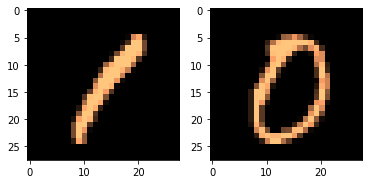

In [959]:
#/////////////////////////////////////////////////////////////////////////////////////// <parsing des fichiers de données> ////

# ··· Dans l'ordre, MNIST puis USPS.

numbers = pd.read_csv('mnist_train.csv')
trainX = np.array(numbers.iloc[:,1:])
# trainX = MinMaxScaler().fit_transform(trainX)
trainY = np.array(numbers['label'])
figures = pd.read_csv('mnist_test.csv')
testX = np.array(figures.iloc[:,1:])
# testX = MinMaxScaler().fit_transform(testX)
testY = np.array(figures['label'])

N = int(np.sqrt(len(trainX[0])))
shownum = plt.figure()
ax0 = shownum.add_subplot(121)
ax0 = plt.imshow(trainX[508].reshape(N,N),cmap=mymap2)
ax1 = shownum.add_subplot(122)
ax1 = plt.imshow(testX[1907].reshape(N,N),cmap=mymap2)
plt.show()

uspsXTrain,uspsYTrain = loadUSPS("USPS/usps_train.txt")
uspsXTest,uspsYTest = loadUSPS("USPS/usps_test.txt")

#////////////////////////////////////////////////////////////////////////////////////// </parsing des fichiers de données> ////

Précision du perceptron régularisé : train 0.985307, test 0.987718
Précision de la SVM linéaire : train 1.000000, test 0.989253


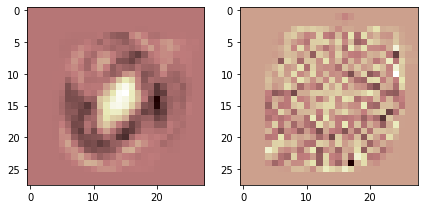

In [960]:
#//////////////////////////////////////////////////////////////////////////////////////////// <régularisation de Tikhonov> ////

# ··· Impact d'une régularisation sur les scores d'une perceptron et comparaison avec la SVM témoin.

xTrain,yTrain = dataset1v1(trainX,trainY,0,8)
xTest,yTest = dataset1v1(testX,testY,0,8)

regeffect = plt.figure(figsize=(7,5))
perceptron = Lineaire(max_iter=1000,eps=0.01,tikhonov=True)
w = perceptron.fit(xTrain,yTrain,xTest,yTest)
scoreTrain,scoreTest = perceptron.score(xTrain,yTrain),perceptron.score(xTest,yTest)
print("Précision du perceptron régularisé : train %f, test %f" %(scoreTrain,scoreTest))
ax0 = regeffect.add_subplot(121)
ax0 = plt.imshow(w.reshape(28,28),cmap='pink')

svm = LinearSVC(max_iter=10000)
svm.fit(xTrain,yTrain)
scoreTrain,scoreTest = svm.score(xTrain,yTrain),svm.score(xTest,yTest)
print("Précision de la SVM linéaire : train %f, test %f" %(scoreTrain,scoreTest))
ax1 = regeffect.add_subplot(122)
ax1 = plt.imshow(svm.coef_.reshape(28,28),cmap='pink')
plt.show()

#/////////////////////////////////////////////////////////////////////////////////////////// </régularisation de Tikhonov> ////

In [945]:
#////////////////////////////////////////////////////////////////////////////////////////////////////// <tinkering around> ////

# ··· Premiers pas avec les structures de sklearn.

xTrain, yTrain = dataset1v1(uspsXTrain,uspsYTrain, 6, 9)
xTest, yTest = dataset1v1(uspsXTest,uspsYTest, 6, 9)

print("Sur deux classes USPS, comparaison entre le perceptron maison et celui de sklearn.")

perceptron = Lineaire(max_iter=1000,eps=0.01)
perceptron.fit(xTrain,yTrain,xTest,yTest)
scoreTrain,scoreTest = perceptron.score(xTrain,yTrain),perceptron.score(xTest,yTest)
print("Précision maison : train %f, test %f" %(scoreTrain,scoreTest))

clf = sklearn.linear_model.Perceptron(alpha = 0.01)
clf.fit(xTrain, yTrain)
score = cross_val_score(clf, xTrain, yTrain, cv=5, scoring='accuracy')
print("Précision sklearn en validation croisée :", np.mean(score))

# Nos performances sont franchement acceptables.

print("\nSur deux classes USPS, comparaison des performances des kernels sklearn avec une Pipeline de scaling.")

for paramk in ['linear','poly','rbf','sigmoid']: 
    svm = SVC(kernel=paramk,gamma='auto')
    clf = make_pipeline(StandardScaler(), svm)
    clf.fit(xTrain, yTrain)
    score = cross_val_score(clf, xTrain, yTrain, cv=5, scoring='accuracy')
    print("// %s // Précision en validation croisée : %.5f" %(paramk,np.mean(score)))
    print("// %s // Nombre de vecteurs support :" %(paramk),svm.n_support_)

print("\nSur deux classes USPS, comparaison des performances des kernels sklearn sans Pipeline.")

for paramk in ['linear','poly','rbf','sigmoid']: 
    clf = SVC(kernel=paramk,gamma='auto')
    clf.fit(xTrain, yTrain)
    score = cross_val_score(clf, xTrain, yTrain, cv=5, scoring='accuracy')
    print("// %s // Précision en validation croisée : %.5f" %(paramk,np.mean(score)))
    print("// %s // Nombre de vecteurs support :" %(paramk),clf.n_support_)
    
# Les résultats ne sont pas sensiblement améliorés avec la pipeline, quoiqu'on n'ait pas vraiment de marge.
# On note surtout que le nombre général de vecteurs support diminue en la retirant, pour des performances similaires
# sinon meilleures - il n'y a donc pas vraiment d'intérêt.
# On sait pourtant que les SVM sont sensibles au scaling des données, on s'étonne un peu du résultat.

#///////////////////////////////////////////////////////////////////////////////////////////////////// </tinkering around> ////

Sur deux classes USPS, comparaison entre le perceptron maison et celui de sklearn.
Précision maison : train 1.000000, test 0.997118
Précision sklearn en validation croisée : 0.9961832061068702

Sur deux classes USPS, comparaison des performances des kernels sklearn avec une Pipeline de scaling.
// linear // Précision en validation croisée : 0.99771
// linear // Nombre de vecteurs support : [24 24]
// poly // Précision en validation croisée : 0.99771
// poly // Nombre de vecteurs support : [165 166]
// rbf // Précision en validation croisée : 0.98777
// rbf // Nombre de vecteurs support : [96 82]
// sigmoid // Précision en validation croisée : 0.99618
// sigmoid // Nombre de vecteurs support : [28 29]

Sur deux classes USPS, comparaison des performances des kernels sklearn sans Pipeline.
// linear // Précision en validation croisée : 0.99847
// linear // Nombre de vecteurs support : [21 22]
// poly // Précision en validation croisée : 0.99771
// poly // Nombre de vecteurs support : [91 

Sur les données artificielles 2D, comparaison des performances des kernels sans Pipeline.
Cette fois, l'afichage des frontières trouvées est envisageable.

Un setting de bruit modéré, sur données linéairement séparables.
// linear // Précision en validation croisée : 1.00000
// linear // Nombre de vecteurs support : [4 3]
// poly // Précision en validation croisée : 0.50400
// poly // Nombre de vecteurs support : [497 497]
// rbf // Précision en validation croisée : 1.00000
// rbf // Nombre de vecteurs support : [4 5]
// sigmoid // Précision en validation croisée : 1.00000
// sigmoid // Nombre de vecteurs support : [5 5]


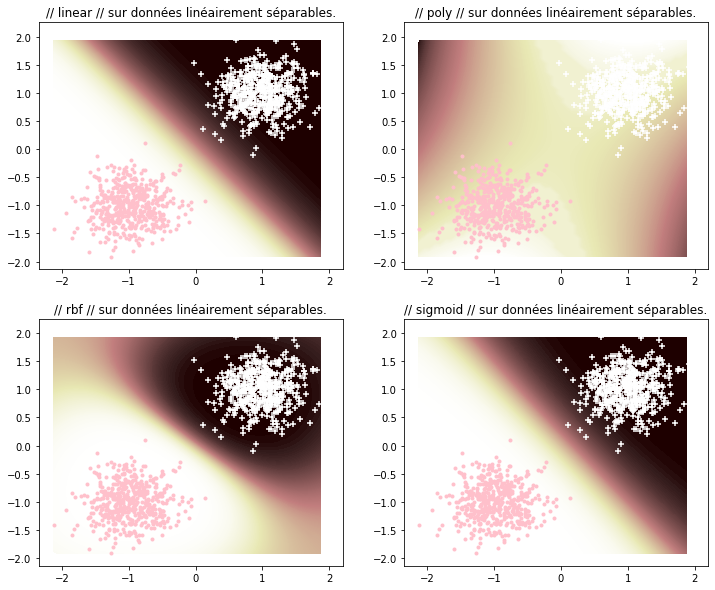


Un setting de bruit modéré, sur données à quatre gaussiennes.
// linear // Précision en validation croisée : 0.69500
// linear // Nombre de vecteurs support : [499 500]
// poly // Précision en validation croisée : 0.99700
// poly // Nombre de vecteurs support : [19 19]
// rbf // Précision en validation croisée : 0.99600
// rbf // Nombre de vecteurs support : [6 6]
// sigmoid // Précision en validation croisée : 0.47900
// sigmoid // Nombre de vecteurs support : [283 282]


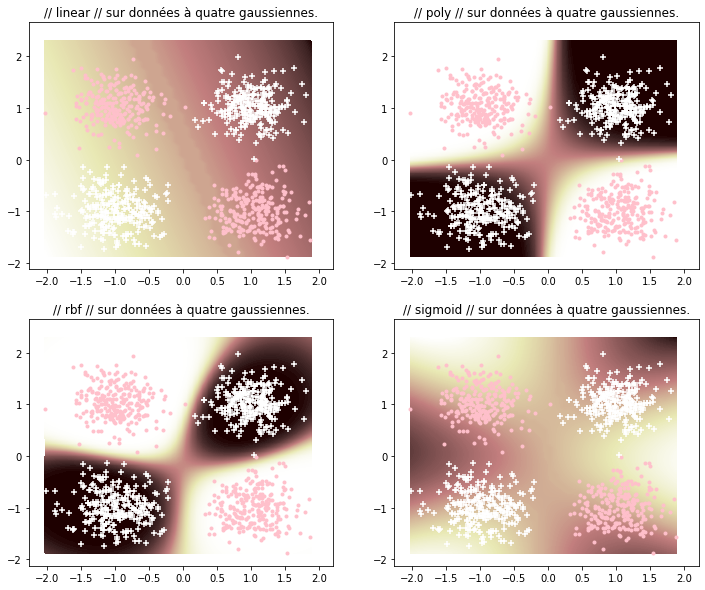


Un setting de bruit modéré, sur données mélangées en échiquier.
// linear // Précision en validation croisée : 0.52900
// linear // Nombre de vecteurs support : [471 487]
// poly // Précision en validation croisée : 0.51493
// poly // Nombre de vecteurs support : [471 480]
// rbf // Précision en validation croisée : 0.74700
// rbf // Nombre de vecteurs support : [323 325]
// sigmoid // Précision en validation croisée : 0.51610
// sigmoid // Nombre de vecteurs support : [260 259]


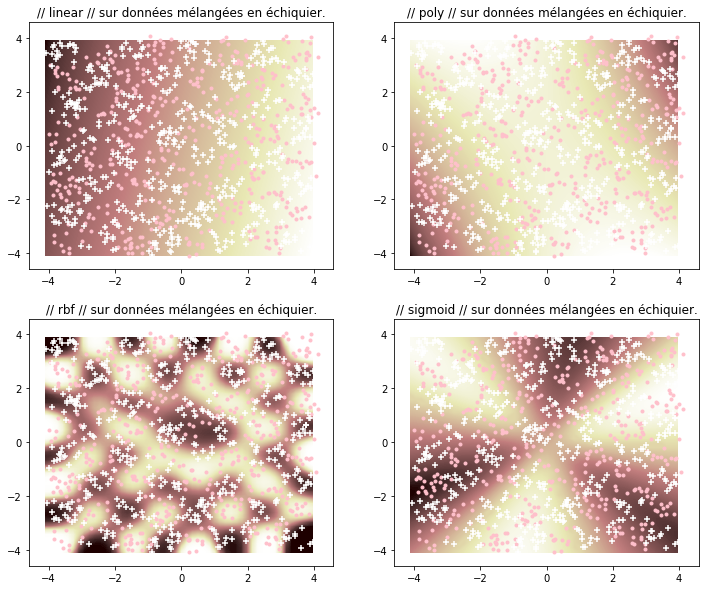


Un setting de bruit plus puissant, sur données linéairement séparables.
// linear // Précision en validation croisée : 0.98300
// linear // Nombre de vecteurs support : [33 33]
// poly // Précision en validation croisée : 0.47400
// poly // Nombre de vecteurs support : [499 500]
// rbf // Précision en validation croisée : 0.98000
// rbf // Nombre de vecteurs support : [32 30]
// sigmoid // Précision en validation croisée : 0.96700
// sigmoid // Nombre de vecteurs support : [30 31]


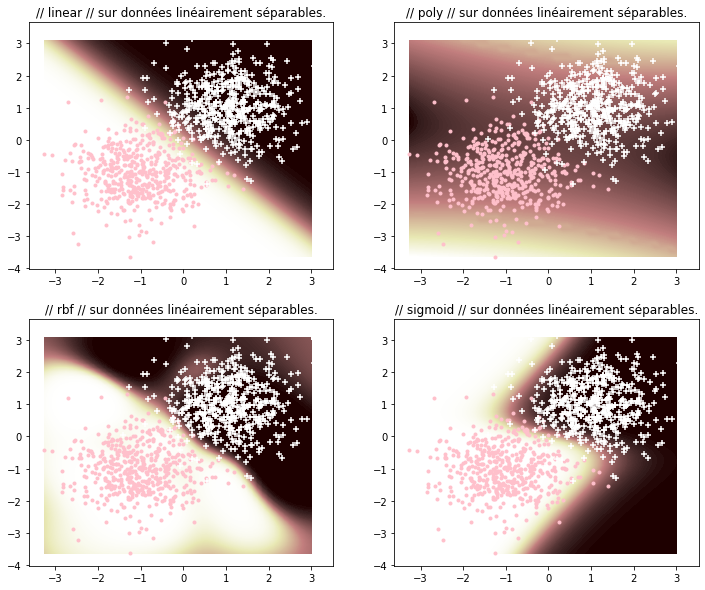


Un setting de bruit plus puissant, sur données à quatre gaussiennes.
// linear // Précision en validation croisée : 0.55000
// linear // Nombre de vecteurs support : [495 496]
// poly // Précision en validation croisée : 0.82500
// poly // Nombre de vecteurs support : [220 222]
// rbf // Précision en validation croisée : 0.81400
// rbf // Nombre de vecteurs support : [202 208]
// sigmoid // Précision en validation croisée : 0.48200
// sigmoid // Nombre de vecteurs support : [263 264]


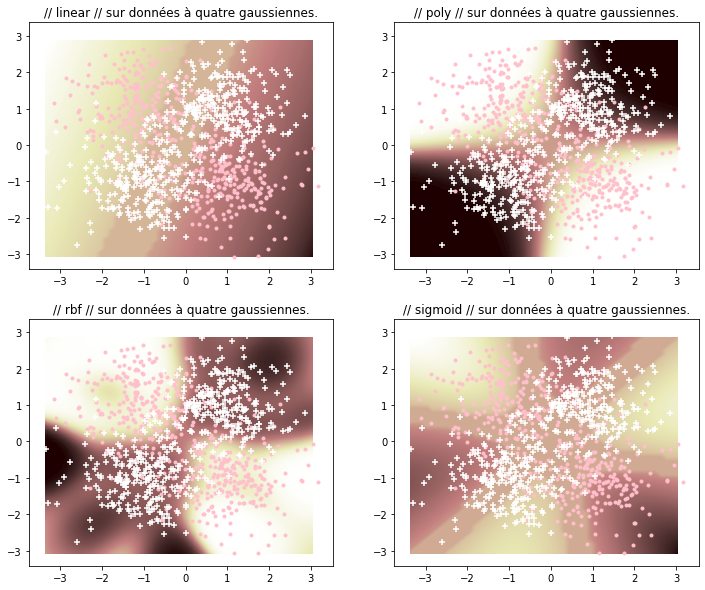


Un setting de bruit plus puissant, sur données mélangées en échiquier.
// linear // Précision en validation croisée : 0.47300
// linear // Nombre de vecteurs support : [498 498]
// poly // Précision en validation croisée : 0.49900
// poly // Nombre de vecteurs support : [493 493]
// rbf // Précision en validation croisée : 0.52200
// rbf // Nombre de vecteurs support : [414 426]
// sigmoid // Précision en validation croisée : 0.49600
// sigmoid // Nombre de vecteurs support : [255 256]


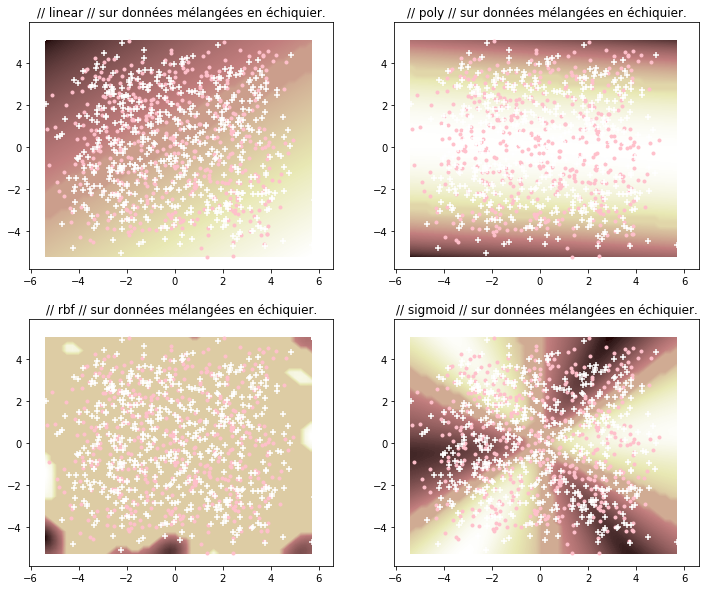

In [747]:
#////////////////////////////////////////////////////////////////////////////////////////// <affichage sur les données 2D> ////

# ··· Sur les données artificielles fournies,
# affichage des frontières trouvées par SVM, avec le flou qui caractérise les marges par rapport au perceptron.

# Par défaut, sklearn affiche des avertissements ConvergenceWarning liés au fait de limiter le nombre d'itérations :
# on est encore loin d'atteindre "tol", la valeur de précision satisfaisante à laquelle l'apprentissage s'arrête 
# automatiquement. Evidemment, notre objectif est de faire les choses en un temps raisonnable, d'où cette limitation 
# qui laisse quand même assez de liberté au classifieur ; et d'expérience, les warnings s'affichent seulement dans 
# les cas où l'algorithme n'est pas du tout adapté aux données (exemple, données type 0 avec classifieur linéaire).
# On se fait donc une joie de les supprimer pour le rendu. Solution copiée de SO.
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
    
print("Sur les données artificielles 2D, comparaison des performances des kernels sans Pipeline.")
print("Cette fois, l'afichage des frontières trouvées est envisageable.")
    
dictdata = {0:'données linéairement séparables', 1:'données à quatre gaussiennes', 2:'données mélangées en échiquier'}
dictepsi = {0:(0.1,'modéré'), 1:(0.7,'plus puissant')}
for eps in range(2):
    for i in range(3):
        xTrain,yTrain = gen_arti(nbex=1000,data_type=i,epsilon=dictepsi[eps][0])
        print("\nUn setting de bruit %s, sur %s." %(dictepsi[eps][1],dictdata[i]))
        oneType = plt.figure(figsize=(12,10))
        graph=1
        for paramk in ['linear','poly','rbf','sigmoid']: 
            clf = SVC(probability=True,kernel=paramk,max_iter=10000)
            if paramk=='rbf':
                clf = SVC(probability=True,kernel=paramk,gamma='auto',C=100,max_iter=10000)
            if paramk=='poly':
                clf = SVC(probability=True,kernel=paramk,degree=2,max_iter=10000) 
                # degree = 2 pour type 1, se débrouille mieux pour type 0 sans
            clf.fit(xTrain, yTrain)
            score = cross_val_score(clf, xTrain, yTrain, cv=5, scoring='accuracy')
            print("// %s // Précision en validation croisée : %.5f" %(paramk,np.mean(score)))
            print("// %s // Nombre de vecteurs support :" %(paramk),clf.n_support_)
            num = 220+graph
            ax = oneType.add_subplot(num)
            plotFrontiereSVM(xTrain, lambda x: clf.predict_proba(x)[:, 0], step=50)
            plotData(xTrain, yTrain)
            ax.title.set_text("// %s // sur %s." %(paramk,dictdata[i]))
            graph+=1
        plt.show()

# On a ici aussi essayé la Pipeline, ce qui n'a servi qu'à diminer tous les scores (sauf celui de la sigmoïde).

#///////////////////////////////////////////////////////////////////////////////////////// </affichage sur les données 2D> ////

Impact du bruit sur la quantité de vecteurs de support.


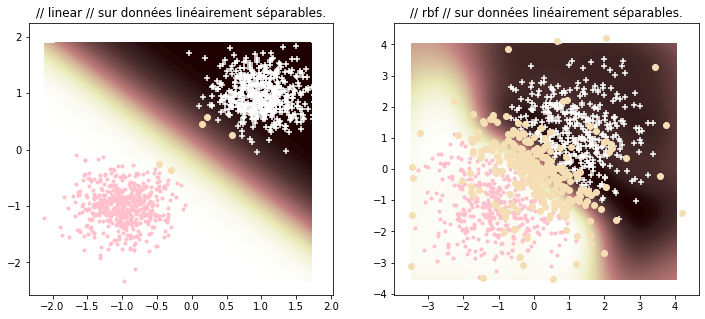

In [774]:
#//////////////////////////////////////////////////////////////////////////////////// <visualisation des vecteurs support> ////

# ··· C'est plus parlant ainsi.

supv = plt.figure(figsize=(12,5))
dictepsi = {0:(0.1,'modéré'), 1:(1,'plus puissant')}
print("Impact du bruit sur la quantité de vecteurs de support.")
# Données linéairement séparables, peu bruitées, noyau linéaire. 
xTrain,yTrain = gen_arti(nbex=1000,data_type=0,epsilon=dictepsi[0][0])
clf = SVC(probability=True,kernel='linear',max_iter=10000)
clf.fit(xTrain, yTrain)
ax1 = supv.add_subplot(121)
plotFrontiereSVM(xTrain, lambda x: clf.predict_proba(x)[:, 0], step=50)
plotData(xTrain, yTrain)
ax1.title.set_text("// %s // sur %s." %('linear',dictdata[0]))
ax1 = plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:, 1], c="wheat")
# Données linéairement séparables, plus bruitées, noyau rbf pour l'expérience.
xTrain,yTrain = gen_arti(nbex=1000,data_type=0,epsilon=dictepsi[1][0])
clf = SVC(probability=True,kernel='rbf',max_iter=10000)
clf.fit(xTrain, yTrain)
ax2 = supv.add_subplot(122)
plotFrontiereSVM(xTrain, lambda x: clf.predict_proba(x)[:, 0], step=50)
plotData(xTrain, yTrain)
ax2.title.set_text("// %s // sur %s." %('rbf',dictdata[0]))
ax2 = plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:, 1], c="wheat")
plt.show()

#/////////////////////////////////////////////////////////////////////////////////// </visualisation des vecteurs support> ////


Un setting de bruit nul, sur données mélangées en échiquier, 20 % de données de train.
scores 0.98 0.723
with params {'C': 1, 'gamma': 10, 'kernel': 'rbf', 'max_iter': 10000, 'probability': True}

Un setting de bruit nul, sur données mélangées en échiquier, 40 % de données de train.
scores 0.9975 0.841
with params {'C': 1000, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 10000, 'probability': True}

Un setting de bruit nul, sur données mélangées en échiquier, 60 % de données de train.
scores 0.995 0.873
with params {'C': 10000, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 10000, 'probability': True}

Un setting de bruit nul, sur données mélangées en échiquier, 80 % de données de train.
scores 0.97125 0.877
with params {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 10000, 'probability': True}

Un setting de bruit nul, sur données mélangées en échiquier, 100 % de données de train.
scores 0.992 0.917
with params {'C': 1000, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 10000, 'probability': True}

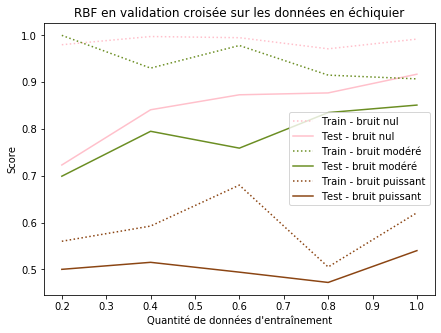

In [802]:
#//////////////////////////////////////////////////////////////////////////// <gridsearch des paramètres : noyau gaussien> ////

# ··· On cherche les meilleurs paramètres pour chaque kernel, chaque type de données, et pour un certain niveau de bruit.
# On prendra soin d'éviter les combinaisons inutiles (comme du linéaire sur le type 1).
# L'usage du kernel sigmoïde est souvent jugé inintéressant par la communauté sur des données comme les nôtres. On passe outre.

# On choisit un cas particulier, celui du noyau gaussien, qu'on soumet à des données de type 2 avec divers niveaux de bruit. 

dictdata = {0:'données linéairement séparables', 1:'données à quatre gaussiennes', 2:'données mélangées en échiquier'}
dictepsi = {0:(0,'nul'), 1:(0.1,'modéré'), 2:(0.5,'puissant')}

gammas = [0.001,0.01,0.1,1,10,100,1000,'auto','scale']
cees = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
degrees = np.arange(2,8)

pardict = { 'probability':[True], 'max_iter':[10000], 'C': cees, 'kernel': ['rbf'],  'gamma': gammas}

noises = {}
for n in range(len(dictepsi)):
    xTrain,yTrain = gen_arti(nbex=1000,data_type=2,epsilon=dictepsi[n][0])
    xTest,yTest = gen_arti(nbex=1000,data_type=2,epsilon=dictepsi[n][0])
    trainsizerbf = {}
    for tsize in np.round(np.linspace(0.2,0.8,4),decimals=2):
        print("\nUn setting de bruit %s, sur %s, %d %% de données de train." %(dictepsi[n][1],dictdata[2],int(tsize*100)))
        trainX, extraX, trainY, extraY = train_test_split(xTrain, yTrain, train_size=tsize)
        modelrbf = GridSearchCV(cv=5,scoring='accuracy', estimator=SVC(), param_grid=pardict, verbose=0, return_train_score=True) 
        modelrbf.fit(trainX, trainY)
        print("scores",modelrbf.score(trainX,trainY),modelrbf.score(xTest,yTest))
        print("with params",modelrbf.best_params_)
        dfrbf = (modelrbf.score(trainX,trainY),modelrbf.score(xTest,yTest))
        trainsizerbf[tsize] = dfrbf            
    print("\nUn setting de bruit %s, sur %s, %d %% de données de train." %(dictepsi[n][1],dictdata[2],100))
    modelrbf = GridSearchCV(cv=5,scoring='accuracy', estimator=SVC(), param_grid=pardict, verbose=0, return_train_score=True) 
    modelrbf.fit(xTrain, yTrain)
    print("scores",modelrbf.score(xTrain,yTrain),modelrbf.score(xTest,yTest))
    print("with params",modelrbf.best_params_)
    dfrbf = (modelrbf.score(xTrain,yTrain),modelrbf.score(xTest,yTest))
    trainsizerbf[100] = dfrbf
    print("\n",trainsizerbf,"\n")
    noises[n] = trainsizerbf
# print("\n\n///////////////////TOTAL///////////////////\n",noises)
# >>> res = {0: {0.2: (0.794, 0.744), 0.4: (0.89, 0.806), 0.6: (0.938, 0.845), 0.8: (0.959, 0.878), 100: (0.992, 0.9)}, 1: {0.2: (0.757, 0.71), 0.4: (0.829, 0.737), 0.6: (0.888, 0.814), 0.8: (0.911, 0.825), 100: (0.936, 0.823)}, 2: {0.2: (0.613, 0.505), 0.4: (0.581, 0.517), 0.6: (0.521, 0.532), 0.8: (0.513, 0.499), 100: (0.971, 0.51)}}

# Passage en graphique.
resistance = pd.DataFrame(noises)
resistance = resistance.to_numpy().T
colors=['pink','olivedrab','saddlebrown']
plt.figure(figsize=(7,5))
plt.title('RBF en validation croisée sur les données en échiquier')
for n in range(len(resistance)):
    # Corriger l'erreur d'avoir mis des tuples...
    scores_train = [np.array(resistance[n][i][0]) for i in range(5)]
    scores_test = [np.array(resistance[n][i][1]) for i in range(5)]
    plt.plot(np.round(np.linspace(0.2,1.0,5),decimals=2), scores_train, color=colors[n], label='Train - {}'.format("bruit "+dictepsi[n][1]), linestyle=':')
    plt.plot(np.round(np.linspace(0.2,1.0,5),decimals=2), scores_test, color=colors[n], label='Test - {}'.format("bruit "+dictepsi[n][1]))   
# Affichage du graphe
plt.xlabel("Quantité de données d'entraînement")
plt.ylabel('Score')
plt.legend()
plt.show()
    
#/////////////////////////////////////////////////////////////////////////// </gridsearch des paramètres : noyau gaussien> ////

In [795]:
#////////////////////////////////////////////////////////////////////////// <gridsearch des paramètres : noyau polynomial> ////

# ··· Il sera soumis à des données de type 1, très bruitées.

cees = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
degrees = np.arange(2,8)
# coefs = bon...

pardict = { 'probability':[True], 'max_iter':[10000], 'C': cees, 'kernel': ['poly'],  'degree': degrees}

xTrain,yTrain = gen_arti(nbex=1000,data_type=1,epsilon=0.7)
xTest,yTest = gen_arti(nbex=1000,data_type=1,epsilon=0.7)    
print("\nUn setting de bruit puissant, sur données à doubles gaussiennes, 100 % de données de train.")
idealply = GridSearchCV(cv=5,scoring='accuracy', estimator=SVC(), param_grid=pardict, verbose=0, return_train_score=True) 
idealply.fit(xTrain, yTrain)
print("scores",idealply.score(xTrain,yTrain),idealply.score(xTest,yTest))
print("with params",idealply.best_params_)

#///////////////////////////////////////////////////////////////////////// </gridsearch des paramètres : noyau polynomial> ////


Un setting de bruit puissant, sur données à doubles gaussiennes, 100 % de données de train.
scores 0.831 0.822
with params {'C': 0.01, 'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'probability': True}


Impact de la GridSearch sur la quantité de vecteurs de support.


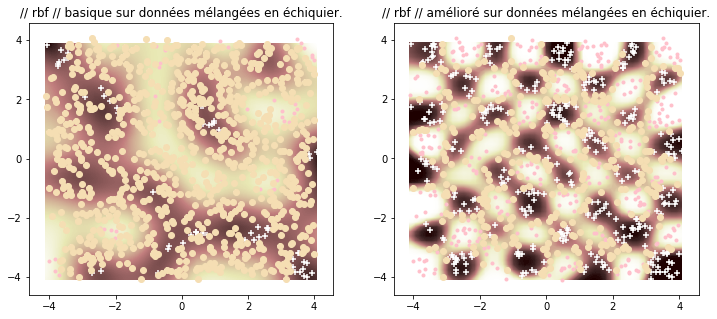


Impact de la GridSearch sur la quantité de vecteurs de support.


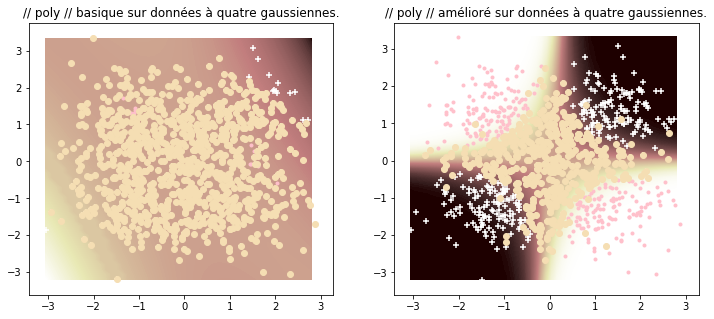

In [801]:
#////////////////////////////////////////////////////////////////////////// <gridsearch des paramètres : vecteurs support> ////

# ··· Constater la diminution des vecteurs de support.

# Pour le noyau gaussien :
supv = plt.figure(figsize=(12,5))
print("Impact de la GridSearch sur la quantité de vecteurs de support.")
xTrain,yTrain = gen_arti(nbex=1000,data_type=2,epsilon=0.1)
# sans GridSearch,
basicrbf = SVC(probability=True,kernel='rbf',max_iter=10000)
basicrbf.fit(xTrain, yTrain)
ax1 = supv.add_subplot(121)
plotFrontiereSVM(xTrain, lambda x: basicrbf.predict_proba(x)[:, 0], step=50)
plotData(xTrain,yTrain)
ax1.title.set_text("// %s // basique sur %s." %('rbf',dictdata[2]))
ax1 = plt.scatter(basicrbf.support_vectors_[:,0], basicrbf.support_vectors_[:, 1], c="wheat")
# avec GridSearch
idealrbf = SVC(probability=True,kernel='rbf',C=1000,gamma=1,max_iter=10000)
idealrbf.fit(xTrain, yTrain)
ax2 = supv.add_subplot(122)
plotFrontiereSVM(xTrain, lambda x: idealrbf.predict_proba(x)[:, 0], step=50)
plotData(xTrain, yTrain)
ax2.title.set_text("// %s // amélioré sur %s." %('rbf',dictdata[2]))
ax2 = plt.scatter(idealrbf.support_vectors_[:,0], idealrbf.support_vectors_[:, 1], c="wheat")
plt.show()

# Pour le noyau polynomial :
supv = plt.figure(figsize=(12,5))
xTrain,yTrain = gen_arti(nbex=1000,data_type=1,epsilon=0.7)
# sans GridSearch,
basicply = SVC(probability=True,kernel='poly',max_iter=10000)
basicply.fit(xTrain, yTrain)
ax1 = supv.add_subplot(121)
plotFrontiereSVM(xTrain, lambda x: basicply.predict_proba(x)[:, 0], step=50)
plotData(xTrain,yTrain)
ax1.title.set_text("// %s // basique sur %s." %('poly',dictdata[1]))
ax1 = plt.scatter(basicply.support_vectors_[:,0], basicply.support_vectors_[:, 1], c="wheat")
# avec GridSearch
ax2 = supv.add_subplot(122)
idealply = SVC(probability=True,kernel='poly',C=0.1,degree=2,max_iter=10000)
idealply.fit(xTrain, yTrain)
plotFrontiereSVM(xTrain, lambda x: idealply.predict_proba(x)[:, 0], step=50)
plotData(xTrain, yTrain)
ax2.title.set_text("// %s // amélioré sur %s." %('poly',dictdata[1]))
ax2 = plt.scatter(idealply.support_vectors_[:,0], idealply.support_vectors_[:, 1], c="wheat")
plt.show()    
      
#///////////////////////////////////////////////////////////////////////// </gridsearch des paramètres : vecteurs support> ////

In [459]:
#///////////////////////////////////////////////////////////////////////////////////// <grid search multiclasses en extra> ////

# ··· On utilise LinearSVC pour savoir comment paramétrer notre propre tâche multiclasses.

parameterslin = { 'max_iter':[10000], 'C': cees }
trainsizelin = {}
for tsize in np.round(np.linspace(0.2,0.8,4),decimals=2):
    print("\nUn GridSearch sur %d %% de données de train." %(int(tsize*100)))
    trainX, extraX, trainY, extraY = train_test_split(uspsXTrain, uspsYTrain, test_size=(1-tsize))
    modellin = GridSearchCV(cv=5,scoring='accuracy', estimator=LinearSVC(), param_grid=parameterslin, verbose=0, return_train_score=True) 
    modellin.fit(trainX, trainY)
    print("scores",modellin.score(uspsXTest,uspsYTest))
    print("with params",modellin.best_params_)
    dflin = modellin.cv_results_
    trainsizelin[tsize] = dflin
print("\nUn GridSearch sur 100% de données de train.")
modellin = GridSearchCV(cv=5,scoring='accuracy', estimator=LinearSVC(), param_grid=parameterslin, verbose=0, return_train_score=True) 
modellin.fit(uspsXTrain, uspsYTrain)
print("test scores",modellin.score(uspsXTest,uspsYTest))
print("with params",modellin.best_params_)

# On retient C = 0.01.
    
#///////////////////////////////////////////////////////////////////////////////////// </grid search multiclasses en extra> ////


Un GridSearch sur 100% de données de train.
scores 0.916791230692576
with params {'C': 0.01, 'max_iter': 10000}


In [ ]:
#////////////////////////////////////////////////////////////////////////////////////////// </reconnaissance multiclasses> ////

# ··· La technique 1 vs. 1 consiste à entraîner autant de classifieurs que de couples d'étiquettes possibles,
# pour savoir trancher à chaque fois entre deux. On choisit alors la classe qui gagne face à toutes les autres,
# celle pour laquelle votent un maximum de sous-SVMs.
# ··· La technique 1 vs. Ω consiste à entraîner autant de classifieurs que d'étiquettes possibles. Pour chaque élément de 
# test, La décision est alors prise en faveur du label qu'on sépare le plus facilement du reste.

def launchOneVOne(kernels,train,test,C=1,gamma='auto',degree=3,hurryup=False):
    # Combien y a-t-il de classes en tout ?
    labels = sorted(set(train[1]))
    N = len(labels)
    for kernel in ['linear']:
        lhoods = {} # Le maximum ici permettra de retenir la meilleure classification.
        for i in range(N):
            for j in range(i,N):
                # A chaque classifieur SVM échoit un couple d'étiquettes qu'il devra discerner.
                svm = SVC(probability=True, kernel=kernel, C=C, gamma=gamma, degree=degree, max_iter = 10000)
                thislabel = list(train[0][np.where(train[1]==labels[i])])
                thisonetoo = list(train[0][np.where(train[1]==labels[j])])
                # Etiquettes positives et négatives.
                if hurryup:
                    # Equilibrer les classes, s'il le faut.
                    thislabel = random.sample(thislabel,min(len(thislabel),len(thisonetoo)))
                    thisonetoo = random.sample(thisonetoo,len(thislabel))
                trainX = np.vstack((np.array(thislabel),np.array(thisonetoo)))
                trainY = np.hstack((np.ones((len(thislabel))),np.zeros((len(thisonetoo)))))
                svm.fit(trainX,trainY)
                # Résultats de l'apprentissage sur les données de test. Mise en mémoire.
                found = svm.predict_proba(test[0])[:,1]
                if i in lhoods.keys(): lhoods[i].append(found)
                else: lhoods[i] = [found]
                if j in lhoods.keys(): lhoods[j].append(1-found)
                else: lhoods[j] = [1-found]
        # Calculer la note moyenne de chaque classe sur toutes les machines,
        lhoods = np.mean([np.array(lhoods[i]) for i in labels],axis=1)
        # avant de décréter laquelle est la meilleure.
        preds = np.argmax(lhoods,axis=0)
        print("Score obtenu pour un noyau %s après épissage, %.5f"%(kernels[kernel],np.mean(preds == test[1])))

def launchOneVAll(kernels,train,test,C=1,gamma='auto',degree=3,hurryup=False):
    # Combien y a-t-il de classes au total ?
    labels = sorted(set(train[1]))
    N = len(labels)
    # Garder une trace de ce qui est fait.
    performances = []
    for kernel in list(kernels.keys()):
        # scores = [] # Juste pour information.
        lhoods = [] # Le maximum ici permettra de retenir la meilleure classification.
        for i in range(N):
            # A chaque classifieur SVM échoit une étiquette particulière de données qu'il devra gérer.
            svm = SVC(probability=True, kernel=kernel, C=C, gamma=gamma, degree=degree, max_iter = 10000)
            # Etiquettes positives et négatives.
            thislabel = list(train[0][np.where(train[1]==labels[i])])
            allothers = list(train[0][np.where(train[1]!=labels[i])])
            if hurryup:
                # Equilibrer les classes, c'est supposément améliorer les scores, mais surtout 
                # gagner beaucoup de temps dans le cadre d'un one vs. all.
                thislabel = random.sample(thislabel,min(len(thislabel),len(allothers)))
                allothers = random.sample(allothers,len(thislabel))
            trainX = np.vstack((np.array(thislabel),np.array(allothers)))
            trainY = np.hstack((np.ones((len(thislabel))),np.zeros((len(allothers)))))
            svm.fit(trainX,trainY)
            # Résultats de l'apprentissage sur les données de test. Mise en mémoire.
            # scores.append(svm.score(test[0],test[1]))
            lhoods.append(svm.predict_proba(test[0])[:,1])
        # On associe alors à chaque élément la classe qui maximise le score des classifieurs. 
        preds = np.argmax(lhoods,axis=0)
        # print("Attention, le score moyen général pour %s est %.5f"%(kernel,np.mean(scores)))
        thiskernel = np.mean(preds == test[1])
        performances.append(thiskernel)
        if not hurryup:
            print("Score obtenu pour un noyau %s après épissage, %.5f"%(kernels[kernel],thiskernel))
    return performances

# Passage en test, 1v1, 1vΩ.
kernels = {'linear':'linéaire','poly':'polynomial','rbf':'gaussien'}

# Le fait de réduire les classes ne change pas grand chose pour la première méthode (elles sont à peu près équilibrées).
print("One vs. One, résultats après rééqulilibrage des classes (sans grand impact).")
launchOneVOne(kernels,[uspsXTrain,uspsYTrain],[uspsXTest,uspsYTest],hurryup=True)
print("One vs. One, résultats sans rééqulilibrage (sans grand impact).")
launchOneVOne(kernels,[uspsXTrain,uspsYTrain],[uspsXTest,uspsYTest],hurryup=False)
# Ici par contre, si.
print("\nOne vs. All, résultats après rééqulilibrage des classes (cinq validations).")
toMean = np.array([launchOneVAll(kernels,[uspsXTrain,uspsYTrain],[uspsXTest,uspsYTest],hurryup=True) for i in range(5)])
aff = 0
for kernel in kernels:
    print("Score moyen pour un noyau %s, %.5f"%(kernels[kernel],np.mean(toMean,axis=0)[aff]))
    aff += 1
print("\nOne vs. All, résultats sans aucun rééquilibrage, censément mauvais.")
launchOneVAll(kernels,[uspsXTrain,uspsYTrain],[uspsXTest,uspsYTest],hurryup=False)
# Et pourtant, c'est mieux de faire sans ? 
# A relancer pour observation.

#////////////////////////////////////////////////////////////////////////////////////////// </reconnaissance multiclasses> ////

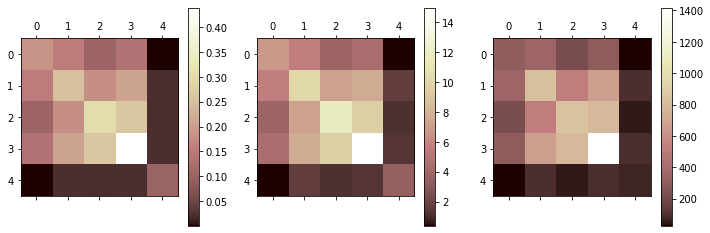

In [882]:
#///////////////////////////////////////////////////////////////////////////////////////////////////////// <string kernel> ////

# Mise en oeuvre du String Kernel tel que compris, et essais sur des histoires de poires.

def stringSimilarity(s1,s2,lam=0.5):
    # Ce calcul n'est fait que sur les bigrammes. On voit mal comment
    # 1) vectoriser le calcul, car les boucles sont très chronophages, 
    # 2) étendre la chose à des n-grammes ? 
    # >> il faudrait alors n boucles par traitement de chaîne ?
    vect1 = []
    for i in range(0,len(s1)):
        for j in range(i+1,len(s1)):
                vect.append((s1[i]+s1[j],j-i))
    vect2 = []
    for i in range(0,len(s2)):
        for j in range(i+1,len(s2)):
            vect2.append((s2[i]+s2[j],j-i))
    sim = 0
    for a in vect1:
        for b in vect2:
            if a[0] == b[0]:
                sim += lam**(a[1]+b[1])
    return sim

def compMatrix(database,lam):
    mat = np.zeros((len(database),len(database)))
    for i in range(len(database)):
        for j in range(len(database)):
            mat[i,j]=getSim(database[i],database[j],lam)
    return mat

# Test et assurance pour les gaps.
scoubidous = ['manger des pommes','manger de bonnes poires','bonnes juteuses poires','bonnes mais pathétiques poires','rien à voir']
allMatrices = plt.figure(figsize=(12,4))
ax1 = allMatrices.add_subplot(131)
i = ax1.matshow(compMatrix(scoubidous,0.1),cmap='pink')
plt.colorbar(i)
ax2 = allMatrices.add_subplot(132)
i = ax2.matshow(compMatrix(scoubidous,0.5),cmap='pink')
plt.colorbar(i)
ax3 = allMatrices.add_subplot(133)
i = ax3.matshow(compMatrix(scoubidous,1),cmap='pink')
plt.colorbar(i)
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////////////////// </string kernel> ////

In [934]:
#///////////////////////////////////////////////////////////////////////////////////////// <préparation des données texte> ////

# ··· Nous avons décidé de mettre en place un apprentissage sur des poèmes anglais 
# de l'époque de Wilde et de celle de Shakespeare. Avec un entraînement sur ces deux auteurs seuls,
# on pense pouvoir identifier quelques intertextes. 
# Pour le plaisir, en lançant ce code, vous pourrez tirer quatre vers au sort.

# Parsing des fichiers de données (étiquettes implicites).
poemXTrainS = []
with open('willi','r',encoding='utf-8') as f:
    allines = f.readlines()
    for i,line in enumerate(allines):
        if(re.search('###',line)):
            poemXTrainS.append(allines[i+2]+allines[i+3])
        if(re.search('\*',line)):
            poemXTrainS.append(allines[i+1]+allines[i+2])

# Deux vers de Shakespeare !
print(poemXTrainS[np.random.randint(len(poemXTrainS))])

poemXTrainW = []
with open('oscar','r',encoding='utf-8') as f:
    allines = f.readlines()
    for i,line in enumerate(allines):
        if(re.search('###',line)):
            continue
        if(re.search('\*',line)):
            poemXTrainW.append(allines[i+1]+allines[i+2])

# Deux vers de Wilde !
print(poemXTrainW[np.random.randint(len(poemXTrainW))])

poemXTrain = []
for i in range(len(poemXTrainS)):
    # Nettoyage et catalogage des poèmes de Shakespeare.
    tmp = (re.sub("\n"," ",poemXTrainS[i]))
    tmp = (re.sub("--","",tmp))
    poemXTrain.append(re.sub("[^A-Za-z0-9- ]+",'',tmp.strip()).lower())
for i in range(len(poemXTrainW)):
    # Nettoyage et catalogage des poèmes de Wilde.
    tmp = (re.sub("\n"," ",poemXTrainW[i]))
    tmp = (re.sub("--","",tmp))
    poemXTrain.append(re.sub("[^A-Za-z0-9- ]+",'',tmp.strip()).lower())

# Aperçu.
print(poemXTrain[70:90],"\n\n",poemXTrain[1095:1115],"\n")

# Longueur totale : 2095, Shakespeare jusqu'à 1063, puis Wilde.

#///////////////////////////////////////////////////////////////////////////////////////// <préparation des données texte> ////

Then can I grieve at grievances foregone,
And heavily from woe to woe tell o'er

That not dishonoured should thy soul go down
To tell the mighty Sire of thy race

['and that fresh blood which youngly thou bestowest thou mayst call thine when thou from youth convertest', 'herein lives wisdom beauty and increase without this folly age and cold decay', 'if all were minded so the times should cease and threescore year would make the world away', 'let those whom nature hath not made for store harsh featureless and rude barrenly perish', 'look whom she best endowd she gave the more which bounteous gift thou shouldst in bounty cherish', 'she carved thee for her seal and meant thereby thou shouldst print more not let that copy die', 'when i do count the clock that tells the time and see the brave day sunk in hideous night', 'when i behold the violet past prime and sable curls all silverd oer with white', 'when lofty trees i see barren of leaves which erst from heat did canopy the herd', 'and s

611.8021919727325


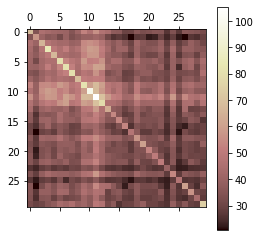

In [875]:
#//////////////////////////////////////////////////////////////////////////////////////////////// <quelques vérifications> ////

# ··· Génération de la matrice de similarité.
t=time.time()
plt.matshow(compMatrix(poemXTrain[1050:1080],0.5),cmap='pink')
plt.colorbar()
print(time.time()-t)

# La matrice montre une plus grande similarité entre les Shakespeare. 
# Mais la lenteur du code (dix minutes pour comparer trente extraits) est vraiment rédhibitoire.
# On n'utilisera donc pas la fonction de String Kernel pour la classification, mais bien une version moins complexe 
# qui calcule les ressemblances dans le vocabulaire.

#/////////////////////////////////////////////////////////////////////////////////////////////// </quelques vérifications> ////

In [883]:
#//////////////////////////////////////////////////////////////////////////////////////////// <string kernel, reconsidéré> ////

# ··· Une mesure qui concerne le vocabulaire des poèmes.
def stringSimilarity(s1,s2):
    w1 = s1.split()
    w2 = s2.split()
    common_words = set(w1).intersection(set(w2))
    c1 = Counter(w1)
    c2 = Counter(w2)
    return sum([c1[w]+c2[w] for w in common_words])/(len(w1)+len(w2))

#/////////////////////////////////////////////////////////////////////////////////////////// </string kernel, reconsidéré> ////

In [936]:
#//////////////////////////////////////////////////////////////////////////////////////////// <association des étiquettes> ////

# ··· On a fait en sorte que les deux classes soient équilibrées.
# Histoire de s'assurer que les apprentissages partiels (notamment en validation croisée) sont quand même représentatifs,
# il faut que les étiquettes soient représentées de façon équitable quelle que soit la partition.
poemYTrain = ([1]*len(poemXTrainS) + [-1]*len(poemXTrainW))
idx = np.random.permutation(len(poemXTrain))
poemXTrain = np.take(poemXTrain,idx)
poemYTrain = np.take(poemYTrain,idx)

# Paré au lancement.

#/////////////////////////////////////////////////////////////////////////////////////////// </association des étiquettes> ////

In [879]:
#/////////////////////////////////////////////////////////////////////////////////////// <essais d'apprentissage built-in> ////

# ··· On fait d'abord des essais sur les données avec des kernels classiques :

param = {'clf__C': cees}
clf = Pipeline([('vect',CountVectorizer()), ('clf',LinearSVC(max_iter=10000))])
grid = GridSearchCV(clf, param_grid=param)
grid.fit(poemXTrain,poemYTrain)
print("Linéaire, score ",grid.score(poemXTrain,poemYTrain))
print("ou plus justement ",cross_val_score(grid,poemXTrain,poemYTrain,cv=5,scoring='accuracy'))
print("avec les paramètres ",grid.best_params_)

svm = Pipeline([('vect',CountVectorizer()),('clf',SVC(kernel='rbf',C=1000,max_iter=10000))])
svm.fit(poemXTrain,poemYTrain)
print("\nGaussien, score ",svm.score(poemXTrain,poemYTrain))
print("ou plus justement ",cross_val_score(svm,poemXTrain,poemYTrain,cv=5,scoring='accuracy'))

#////////////////////////////////////////////////////////////////////////////////////// </essais d'apprentissage built-in> ////

Linéaire, score  0.9985680190930788
ou plus justement  [0.87380952 0.86904762 0.89498807 0.86124402 0.87799043]
avec les paramètres  {'clf__C': 0.1}

Gaussien, score  0.9985680190930788
ou plus justement  [0.86904762 0.87142857 0.89976134 0.84449761 0.87799043]


In [938]:
#///////////////////////////////////////////////////////////////////////////////////////// </lancement de l'apprentissage> ////

# ··· On passe à notre version des faits.
# Le string kernel ne peut pas être utilisé tel quel pour des histoires de conversion de "string" en "float".
# Selon https://stackoverflow.com/questions/26391367/how-to-use-string-kernels-in-scikit-learn,
# il faut donc ruser en présentant les données comme un vecteur d'indices, et adapter la fonction de kernel en conséquence.

def stringSim(X,Y,lam=0.6):
    R = np.zeros((len(X), len(Y)))
    for s1 in X:
        for s2 in Y:
            # Il faut juste passer par les indices au lieu d'agir directement sur les données.
            w1 = poemXTrain[int(s1)].split()
            w2 = poemXTrain[int(s2)].split()
            common_words = set(w1).intersection(w2)
            c1 = Counter(w1)
            c2 = Counter(w2)
            # La transformation s1-X[0] permet d'éviter les problèmes d'indices si on ne prend pas les données en entier
            # (c'est ce dont on a besoin pour une cross-validation).
            R[int(s1-X[0]),int(s2-Y[0])] = sum([lam**(c1[w]+c2[w]) for w in common_words])
    return R

print("Passage en mode artisanal.")
allX = np.arange(len(poemXTrain)).reshape(-1, 1)
subX = np.arange(1500).reshape(-1, 1)
subX2 = np.arange(1500,2095).reshape(-1, 1)

# Déjà, la SVM est tout à fait capable d'apprendre parfaitement les données (100% de précision).
svm = SVC(kernel=stringSim,C=100,max_iter=10000)
svm.fit(allX,poemYTrain)
svm.score(allX,poemYTrain)
print(np.around(svm.score(allX,poemYTrain)*100), "de bonne classification sur les données de train")
# C(1000) = 0.9952267303102625

# Mais c'est bien plus intéressant en laissant le test à part :
svm.fit(subX,poemYTrain[:1500])
print(np.around(svm.score(subX2,poemYTrain[1500:])*100), "de bonne classification sur un ratio train/test d'environ 70%")  
# C(1000) = 0.8689075630252101, C(0.00001) = 0.5109243697478991

# On tente une cross-validation maison (celle de sklearn donne des problèmes d'indices) :
cees = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
tabc = []
for c in cees:
    svm = SVC(kernel=stringSim,C=c,max_iter=5000)
    thisc = []
    for i in range(5):
        idx = np.random.permutation(len(poemXTrain))
        poemXTrain = np.take(poemXTrain,idx)
        poemYTrain = np.take(poemYTrain,idx)
        subX = np.arange(1500).reshape(-1, 1)
        subX2 = np.arange(1500,2095).reshape(-1, 1)
        svm.fit(subX,poemYTrain[:1500])
        thisc.append(svm.score(subX2,poemYTrain[1500:]))
    tabc.append(np.mean(np.array(thisc)))
    print(tabc)
bestc = cees[np.argmax(tabc)]

# Résultat (ne pas hésiter à commenter les lignes, trop long pour le jouer deux fois)
# tabc = [0.48638655462184877, 0.508235294117647, 0.746890756302521, 0.8245378151260505, 0.8598319327731092, 0.8615126050420168, 0.8652100840336134, 0.8638655462184875, 0.8578151260504201]

#///////////////////////////////////////////////////////////////////////////////////////// </lancement de l'apprentissage> ////

Passage en mode artisanal.
100.0 de bonne classification sur les données de train
85.0 de bonne classification sur un ratio train/test d'environ 70%
[0.49344537815126055]
[0.49344537815126055, 0.492436974789916]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235, 0.837983193277311]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235, 0.837983193277311, 0.8608403361344539]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235, 0.837983193277311, 0.8608403361344539, 0.8561344537815125]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235, 0.837983193277311, 0.8608403361344539, 0.8561344537815125, 0.8668907563025211]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235, 0.837983193277311, 0.8608403361344539, 0.8561344537815125, 0.8668907563025211, 0.861512605042017]
[0.49344537815126055, 0.492436974789916, 0.7741176470588235, 0.837983193277311, 0.8608403361344539, 0.8561344537815125, 0.866890

In [735]:
#/////////////////////////////////////////////////////////////////////////// <aurait été utile pour fine-tuning de lambda> ////

# Le classifieur ultime.
svm = SVC(kernel=stringSim,C=bestc,max_iter=5000)
svm.fit(subX,poemYTrain[:1500])
print(svm.score(subX2,poemYTrain[1500:])) 

#////////////////////////////////////////////////////////////////////////// </aurait été utile pour fine-tuning de lambda> ////

0.8722689075630252


In [926]:
#/////////////////////////////////////////////////////////////////////////// <plus loin dans l'apprentissage, préparation> ////

# ··· La SVM qu'on vient de calibrer est-elle capable de reconnaître des données de test issues d'une distribution différente, 
# des poèmes écrits non plus par W et S seuls, mais par des contemporains ?

# Parsing des fichiers de données (étiquettes déclarées à la place du titre).
poemXTest = []
poemYTest = []
understand = {-1:'Wildian', 1:'Shakespearian'}

longueurPoemes = []
longueur = 0
with open('test','r',encoding='utf-8') as f:
    allines = f.readlines()
    for i,line in enumerate(allines):
        if(re.search('###',line)):
            balise = line[4]
            poemXTest.append(allines[i+2]+allines[i+3])
            longueurPoemes.append(longueur)
            longueur += 1
            if balise == 'S': poemYTest.append(1)
            else: poemYTest.append(-1)
        if(re.search('\*',line)):
            poemXTest.append(allines[i+1]+allines[i+2])
            longueur += 1
            if balise == 'S': poemYTest.append(1)
            else: poemYTest.append(-1)
    longueurPoemes.append(longueur)

# Vérification.
print(poemXTest[1],":",understand[poemYTest[1]])

for i in range(len(poemXTest)):
    # Nettoyage et catalogage des poèmes de test.
    tmp = (re.sub("\n"," ",poemXTest[i]))
    tmp = (re.sub("--","",tmp))
    poemXTest[i] = (re.sub("[^A-Za-z0-9- ]+",'',tmp.strip()).lower())
    
#/////////////////////////////////////////////////////////////////////////// <plus loin dans l'apprentissage, préparation> ////

And his love-kindling fire did quickly steep
In a cold valley-fountain of that ground;
 : Shakespearian


In [927]:
#//////////////////////////////////////////////////////////////////////// <plus loin dans l'apprentissage, mise en oeuvre> ////

allXT = np.arange(len(poemXTest)).reshape(-1, 1)

# Reprendre le classifieur ultime.
svm = SVC(kernel=stringSim,C=100,max_iter=5000)
svm.fit(allX,poemYTrain)
print(svm.score(allXT,poemYTest))

#//////////////////////////////////////////////////////////////////////// <plus loin dans l'apprentissage, mise en oeuvre> ////

0.4918032786885246


In [928]:
#//////////////////////////////////////////////////////////////////////// <plus loin dans l'apprentissage, posttraitement> ////

# Lissage en fonction des limites de chaque poème : prédiction de la valeur moyenne pour chaque texte.
preds = svm.predict(allXT)

for i in range(len(longueurPoemes)-1):
    preds[longueurPoemes[i]:longueurPoemes[i+1]] = np.where(np.mean(preds[longueurPoemes[i]:longueurPoemes[i+1]])<0,-1,1) 
print("Score final", np.mean(preds == poemYTest))
print("\n",np.where(preds>0,'S','W'))

# Bon...
# On se console en constatant que les auteurs connus (Wilde et Shakespeare eux-mêmes, car il y a d'eux quatre poèmes en test) 
# sont correctement classés dans cet ensemble. On se rend compte d'ailleurs que c'est en fait très satisfaisant : 

print("\nComparaison avec les performances sklearn:")
svm = SVC(kernel='linear',C=1,max_iter=5000)
svm.fit(allX,poemYTrain)
print("Score pour un kernel linéaire,", svm.score(allXT,poemYTest), "(aucun moyen d'aller plus loin)") 
# print(np.where(svm.predict(allXT)>0,'Shakespearian','Wildian'))

svm = SVC(kernel='rbf',C=1,max_iter=5000)
svm.fit(allX,poemYTrain)
print("Score pour un kernel gaussien,", svm.score(allXT,poemYTest), "(idem)") 
# print(np.where(svm.predict(allXT)>0,'Shakespearian','Wildian'))

#//////////////////////////////////////////////////////////////////////// <plus loin dans l'apprentissage, posttraitement> ////

Score final 0.48633879781420764

 ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W'
 'W' 'W' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'W' 'W' 'W' 'W' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W' 'W' 'W'
 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W'
 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S']

Comparaison avec les performances sklearn:
Score pour un kernel linéaire, 0.4098360655737705 (aucun moyen d'aller plus loin)
Score pour un kernel gaussien, 0.5737704918032787 (idem)
